In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import butter, lfilter

In [2]:
def generateChirp(start, end, sr, dur, samples = None):
    '''
    Generates a chirp signal

    Parameters:
    start (float): start frequency of the chirp
    end (float): end frequency of the chirp
    sr (num): sampling rate
    dur (num):  time duration of tone
    '''
    if samples is None:
        samples = int(sr * dur)
    time = np.linspace(0, dur, samples, False)

    linear_chirp = librosa.chirp(fmin=start, fmax=end, sr = sr, length = samples, duration=dur, linear=True)  
    
    return linear_chirp

In [3]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

In [4]:
def signal_info(signal, sample_rate):
    '''
    Displays sampling rate, time duration and number of samples in the signal
    
    Parameters:
    signal (np.array): the signal
    sample_rate (num): sampling rate
    '''
    duration = len(signal)/ sample_rate
    n_samples = int(duration * sample_rate)
    #time = np.arange(0, n_samples) / sample_rate

    print("Sampling Rate:", sample_rate)
    print("Signal time duration: ", duration)
    print("Number of samples: ", n_samples)

In [5]:
sampling_rate = 48000
dur = 0.01075
no_of_reps = 938

distance = 1
v_sound =  343 
delay_duration = round((2*distance)/343, 4)

print(delay_duration)

0.0058


##### **Ideal Transmitted Signal**

**Chirp Signal**
- frequency range = 18-20kHz
- chirp duration = 0.01075s

In [6]:
chirp = generateChirp(18000,20000, sampling_rate, dur,samples=512)

print("Chirp: ")
signal_info(chirp, sampling_rate)

Chirp: 
Sampling Rate: 48000
Signal time duration:  0.010666666666666666
Number of samples:  512


In [7]:
transmitted = np.tile(chirp, no_of_reps) # repeated chirp signal 
#sf.write('transmitted_extended.wav', transmitted, sampling_rate) # tranmitted_extended (740864, 1447, 15.437916666666666)

print("Transmitted Signal: ")
signal_info(transmitted, sampling_rate)

Transmitted Signal: 
Sampling Rate: 48000
Signal time duration:  10.005333333333333
Number of samples:  480256


In [8]:
F_transmitted, A_transmitted = compute_fft(transmitted, sampling_rate)

print("Resolution: ", 24000/len(F_transmitted))

all_F_transmitted = [F_transmitted[np.where(A_transmitted == np.sort(A_transmitted)[::-1][i])] for i in range(10)]
print("Transmitted Signal frequencies: ")
all_F_transmitted

Resolution:  0.09994669509594882
Transmitted Signal frequencies: 


[array([18375.]),
 array([19687.5]),
 array([19593.75]),
 array([18468.75]),
 array([19312.5]),
 array([18750.]),
 array([18281.25]),
 array([18937.5]),
 array([19125.]),
 array([19781.25])]

In [9]:
def plot_spectogram(signal, sr, n_fft = 128, title = "Spectrogram", hop_length = None, win_length = None, ax = None):
    '''
    Displays a spectrogram (Frequency vs Time) for a signal

    Parameters:
    signal (np.array): the signal
    n_fft (num): length of the windowed signal. 
       Default is 128
    title (str): title of plot. Default is "Spectrogram".
    hop_length (int): number of audio samples between adjacent STFT columns. 
        If hop_length is not given then its value is taken as int(n_fft / 4)
    win_length (int <= n_fft): Each frame of audio is windowed by window of this length 
    ax(matplotlib.axes.Axes): The target axes instance for the plot.

    '''
    if hop_length is None:
        hop_length = int(n_fft / 4)
    
    stft = librosa.stft(y=signal, n_fft = n_fft, hop_length = hop_length, win_length = win_length)
    spectrogram = np.abs(stft)
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    
    if hop_length is None:
        hop_length = int(n_fft / 4)  # You can adjust the hop length calculation as needed
    frame_times = librosa.frames_to_time(np.arange(spectrogram.shape[1]), sr=sr, hop_length=hop_length)

    #plt.figure(figsize=(10, 6))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='linear',x_coords=frame_times, ax=ax)
    #print(sr)
    #print(frame_times[len(frame_times)-1])
    
    #plt.ylim(17000,20000)
    
    #plt.colorbar(format='%+2.0f dB')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)

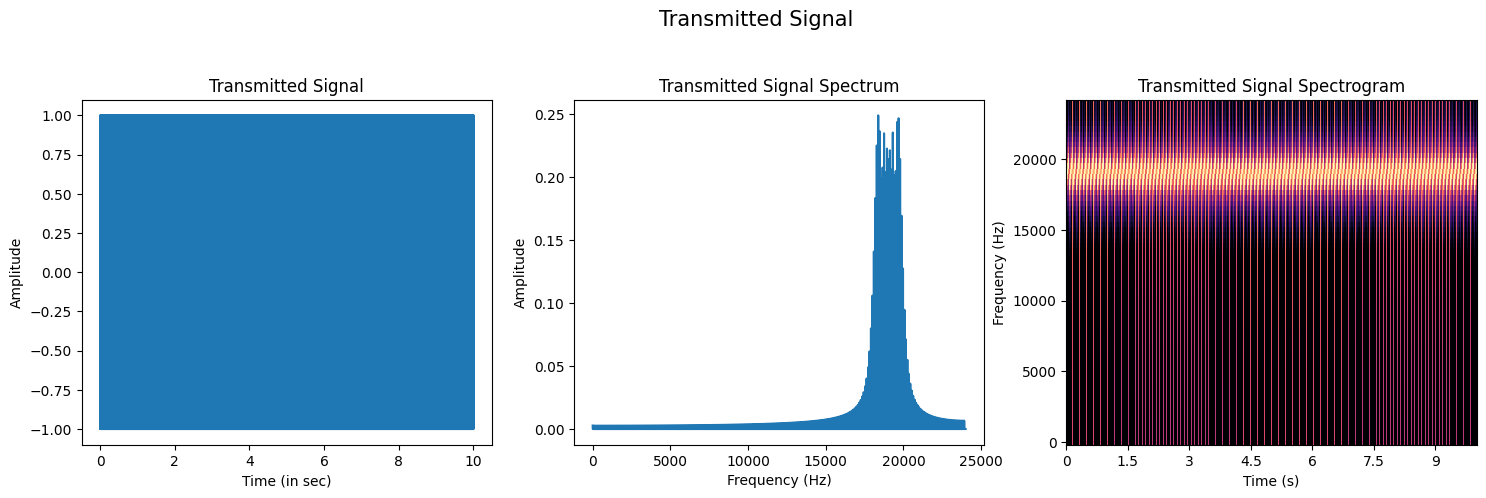

In [10]:
# Transmitted signal 

transmit, (ax1,ax2,ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (18,5))
transmit.suptitle('Transmitted Signal', fontsize = 15)

# Time vs Amplitude plot for the 
ax1.plot([i/sampling_rate for i in range(len(transmitted))], transmitted)
ax1.set_xlabel("Time (in sec)")
ax1.set_ylabel("Amplitude")
ax1.set_title("Transmitted Signal")

# Spectrum
ax2.plot(F_transmitted, A_transmitted)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Transmitted Signal Spectrum')

# Spectrogram 
plot_spectogram(transmitted, sampling_rate, title="Transmitted Signal Spectrogram", ax = ax3)
plt.subplots_adjust(top=0.8)

##### **Ideal Received Signal (with a delay)**

##### **1. Repeated Received Chirp Signal**
- total signal duration = 15.394s

In [11]:
silence = np.zeros(int(sampling_rate * delay_duration))

In [12]:
delayed_signal = np.concatenate((silence, chirp))
received_chirp = np.tile(delayed_signal, no_of_reps)

print("Delayed chirp: ")
signal_info(delayed_signal, sampling_rate)

print("\nReceived Chirp: ")
signal_info(received_chirp, sampling_rate)

#sf.write('received_chirp.wav', received_chirp, sampling_rate)

Delayed chirp: 
Sampling Rate: 48000
Signal time duration:  0.016458333333333332
Number of samples:  789

Received Chirp: 
Sampling Rate: 48000
Signal time duration:  15.437916666666666
Number of samples:  741020


In [13]:
F_rep, A_rep = compute_fft(received_chirp, sampling_rate)

print("Resolution: ", 24000/len(F_rep))

all_F_rep = [F_rep[np.where(A_rep == np.sort(A_rep)[::-1][i])] for i in range(10)]
print("Received Chirp frequencies: ")
all_F_rep

Resolution:  0.06477557960648836
Received Chirp frequencies: 


[array([18349.36708861]),
 array([19564.55696203]),
 array([18713.92405063]),
 array([19625.3164557]),
 array([19686.07594937]),
 array([18410.12658228]),
 array([19260.75949367]),
 array([18470.88607595]),
 array([18896.20253165]),
 array([19078.48101266])]

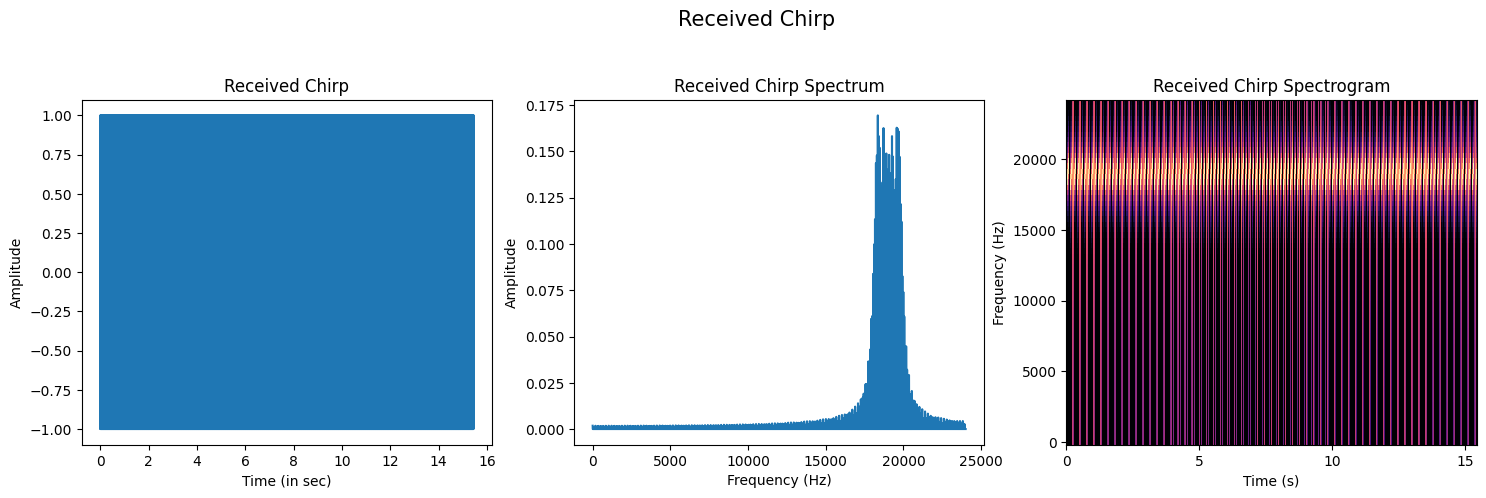

In [14]:
# Received chirp signal 

rec, (ax1,ax2,ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (18,5))
rec.suptitle('Received Chirp', fontsize = 15)

# Time vs Amplitude plot for the 
ax1.plot([i/sampling_rate for i in range(len(received_chirp))], received_chirp)
ax1.set_xlabel("Time (in sec)")
ax1.set_ylabel("Amplitude")
ax1.set_title("Received Chirp")
#plt.xlim(0,0.1)

# Spectrum
ax2.plot(F_rep, A_rep)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Received Chirp Spectrum')

# Spectrogram 
plot_spectogram(received_chirp, sampling_rate, title="Received Chirp Spectrogram", ax = ax3)

plt.subplots_adjust(top=0.8)

##### **2. Repeated Delayed Tone of 11.7Hz**
- total tone duration = 15.394s

In [15]:
def generateAudio(freq, sr, dur, samples=None):
    '''
    Generates a tone (continuous wave)

    Parameters:
    freq (float): frequency of the tone
    sr (num): sampling rate
    dur (num): time duration of tone
    '''
    if samples == None:
        samples = int(sr * dur)
    time = np.linspace(0, dur, samples, False)

    tone = np.sin(2 * np.pi * freq * time)  
    return tone

In [16]:
tone = generateAudio(11.7, sampling_rate, dur, samples=512)

In [17]:
delayed_tone = np.concatenate((silence, tone))
repeated_tone = np.tile(delayed_tone, no_of_reps)

print("Delayed tone: ")
signal_info(delayed_tone, sampling_rate)

print("\nReceived tone: ")
signal_info(repeated_tone, sampling_rate)


Delayed tone: 
Sampling Rate: 48000
Signal time duration:  0.016458333333333332
Number of samples:  789

Received tone: 
Sampling Rate: 48000
Signal time duration:  15.437916666666666
Number of samples:  741020


In [18]:
F_rep_tone, A_rep_tone = compute_fft(repeated_tone,sampling_rate)

print("Resolution: ", 24000/len(F_rep_tone))

all_F_rep_tone = [F_rep_tone[np.where(A_rep_tone == np.sort(A_rep_tone)[::-1][i])] for i in range(10)]
print("Received Chirp frequencies: ")
all_F_rep_tone

Resolution:  0.06477557960648836
Received Chirp frequencies: 


[array([0.]),
 array([60.75949367]),
 array([121.51898734]),
 array([182.27848101]),
 array([243.03797468]),
 array([303.79746835]),
 array([364.55696203]),
 array([425.3164557]),
 array([486.07594937]),
 array([546.83544304])]

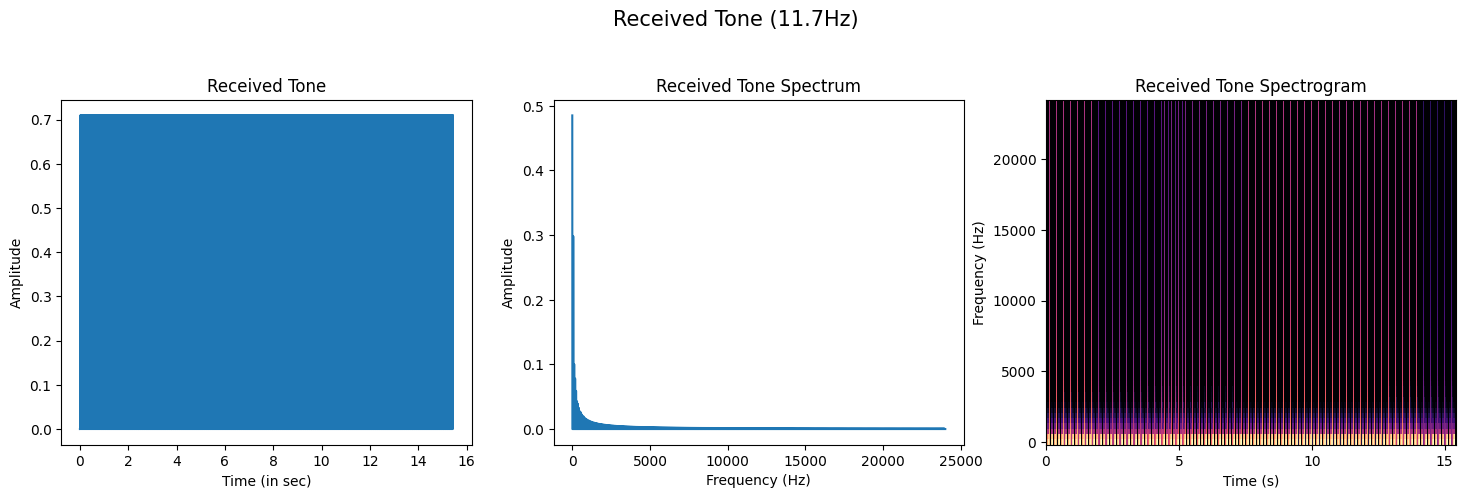

In [19]:
# Received tone

fig3, (ax1,ax2,ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (18,5))
fig3.suptitle('Received Tone (11.7Hz)', fontsize = 15)

# Time vs Amplitude plot for the 
ax1.plot([i/sampling_rate for i in range(len(repeated_tone))], repeated_tone)
ax1.set_xlabel("Time (in sec)")
ax1.set_ylabel("Amplitude")
ax1.set_title("Received Tone")
#plt.xlim(0,0.1)

# Spectrum
ax2.plot(F_rep_tone, A_rep_tone)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Received Tone Spectrum')

# Spectrogram 
plot_spectogram(repeated_tone, sampling_rate, title="Received Tone Spectrogram", ax = ax3)

plt.subplots_adjust(top=0.8)

##### **3. Mixed Received Signal (Chirp + Tone)**
- mixing the delayed chirp (18-20kHz) and the delayed tone (11.7Hz)

In [20]:
mixed_signal_received = delayed_signal + delayed_tone

In [21]:
received = np.tile(mixed_signal_received, no_of_reps)
#sf.write('chirp+tone.wav', received, sampling_rate)

print("Received Signal (Chirp + Tone): ")
signal_info(received,sampling_rate)

Received Signal (Chirp + Tone): 
Sampling Rate: 48000
Signal time duration:  15.437916666666666
Number of samples:  741020


In [22]:
F_mixed_rep, A_mixed_rep = compute_fft(received, sampling_rate)

print("Resolution: ", 24000/len(F_mixed_rep))

all_F_mixed_rep = [F_mixed_rep[np.where(A_mixed_rep == np.sort(A_mixed_rep)[::-1][i])] for i in range(10)]
print("Received Mixed Signal (Chirp and 11.7Hz tone) frequencies: ")
all_F_mixed_rep

Resolution:  0.06477557960648836
Received Mixed Signal (Chirp and 11.7Hz tone) frequencies: 


[array([0.]),
 array([60.75949367]),
 array([18349.36708861]),
 array([18713.92405063]),
 array([19564.55696203]),
 array([19625.3164557]),
 array([19686.07594937]),
 array([19260.75949367]),
 array([18410.12658228]),
 array([18470.88607595])]

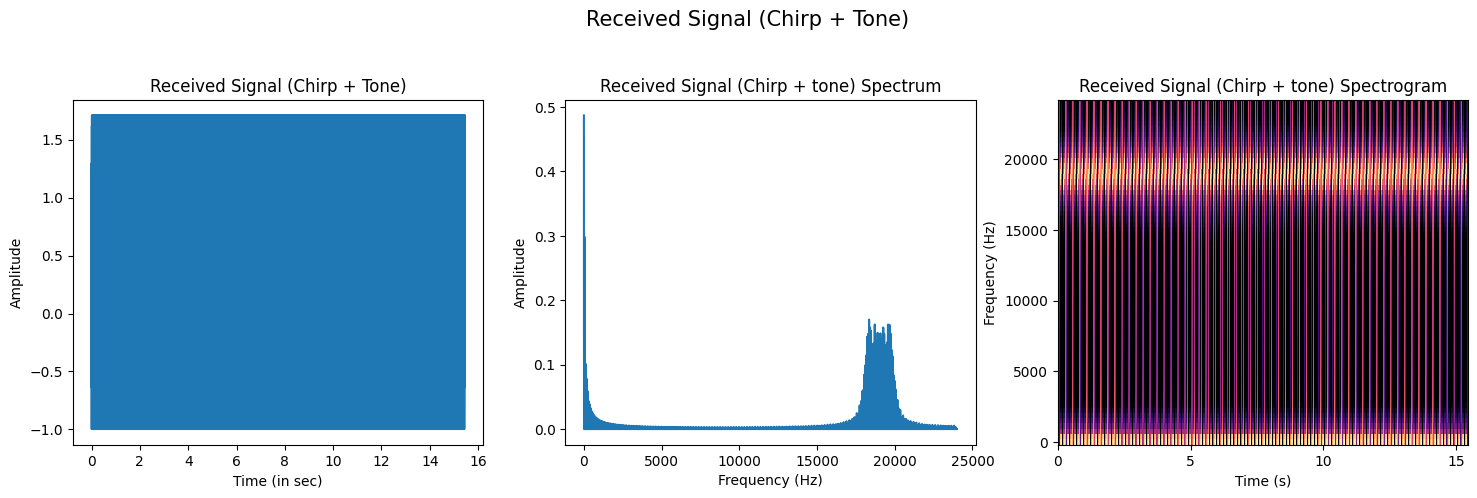

In [23]:
# Received mixed signal (Chirp + Tone)

fig4, (ax1,ax2,ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (18,5))
fig4.suptitle('Received Signal (Chirp + Tone)', fontsize = 15)

# Time vs Amplitude plot for the 
ax1.plot([i/sampling_rate for i in range(len(received))], received)
ax1.set_xlabel("Time (in sec)")
ax1.set_ylabel("Amplitude")
ax1.set_title("Received Signal (Chirp + Tone)")
#plt.xlim(0,0.1)

# Spectrum
ax2.plot(F_mixed_rep, A_mixed_rep)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Received Signal (Chirp + tone) Spectrum')

# Spectrogram 
plot_spectogram(received, sampling_rate, title="Received Signal (Chirp + tone) Spectrogram", ax = ax3)

plt.subplots_adjust(top=0.8)

##### **1. Mixing of Transmitted and Received (Chirp + Tone) Signal**

In [24]:
if transmitted.shape[0] < received.shape[0]:
    received1 = received[:transmitted.shape[0]]
    transmitted1 = transmitted

else:
    transmitted1 = transmitted[:received.shape[0]]
    received1 = received

mixed_chirp_tone = transmitted1 * received1

In [25]:
F,A = compute_fft(mixed_chirp_tone, sampling_rate)

print("Resolution: ", 24000/len(F))

all_F_mixed = [F[np.where(A == np.sort(A)[::-1][i])] for i in range(10)]
print("Mixed Signal frequencies: ")
all_F_mixed

Resolution:  0.09994669509594882
Mixed Signal frequencies: 


[array([18375.]),
 array([19687.5]),
 array([19593.75]),
 array([18468.75]),
 array([19312.5]),
 array([18750.]),
 array([18281.25]),
 array([18937.5]),
 array([19125.]),
 array([19781.25])]

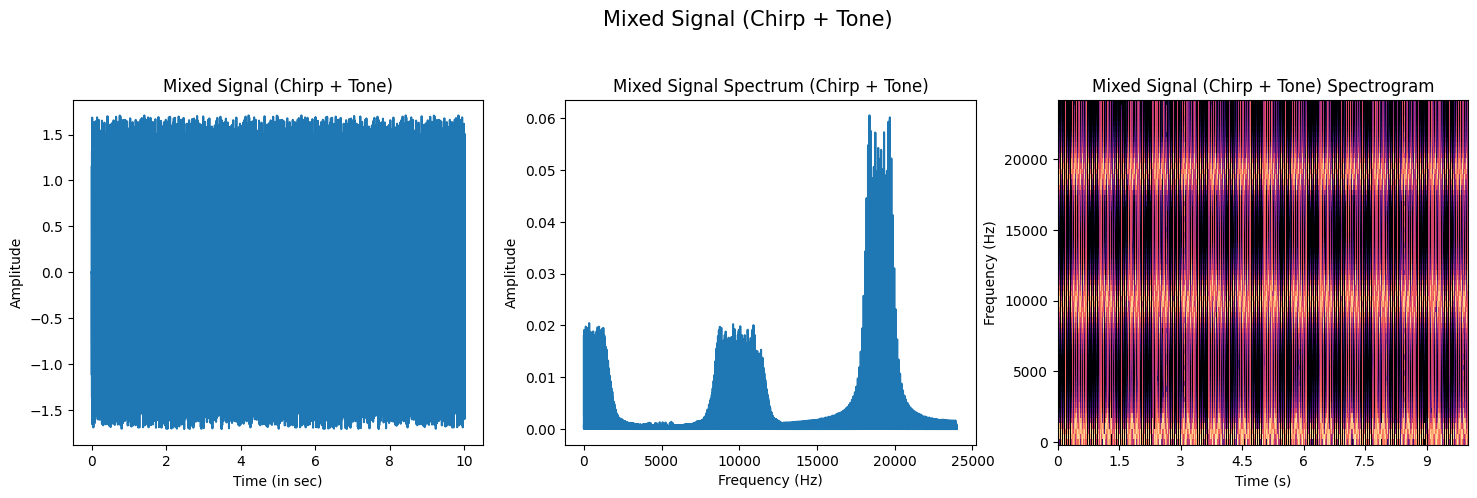

In [26]:
# Mixing Tx and Rx (Chirp + Tone) signal 

fig5, (ax1,ax2,ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (18,5))
fig5.suptitle('Mixed Signal (Chirp + Tone)', fontsize = 15)

# Time vs Amplitude plot for the 
ax1.plot([i/sampling_rate for i in range(len(mixed_chirp_tone))], mixed_chirp_tone)
ax1.set_xlabel("Time (in sec)")
ax1.set_ylabel("Amplitude")
ax1.set_title("Mixed Signal (Chirp + Tone)")
#plt.xlim(0,0.1)

# Spectrum
ax2.plot(F, A)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Mixed Signal Spectrum (Chirp + Tone)')

# Spectrogram 
plot_spectogram(mixed_chirp_tone, sampling_rate, title="Mixed Signal (Chirp + Tone) Spectrogram", ax = ax3)

plt.subplots_adjust(top=0.8)

In [27]:
def butter_lowpass_filter(data, cutoff, fs, order=5):

    '''
    Applies a lowpass Butterworth filter to the input signal and returns the filtered signal.

    Parameters:
    data (np.array): The signal to be filtered
    cutoff (float): The cutoff frequency for the lowpass filter
    fs (float): The sampling rate of the signal
    order (int): The order of the Butterworth filter. Default is 5
    '''
    
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

##### **2. Mixing of Transmitted and Received (Chirp) Signal**

In [28]:
if transmitted.shape[0] < received.shape[0]:
    received_chirp1 = received_chirp[:transmitted.shape[0]]
    transmitted1 = transmitted

else:
    transmitted1 = transmitted[:received_chirp.shape[0]]
    received_chirp1 = received_chirp

mix = transmitted1 * received_chirp1

In [29]:
F_mix,A_mix = compute_fft(mix, sampling_rate)

print("Resolution: ", 24000/len(F))

all_F_mix = [F_mix[np.where(A_mix == np.sort(A_mix)[::-1][i])] for i in range(10)]
print("Mixed Signal (Chirp) frequencies: ")
all_F_mix

Resolution:  0.09994669509594882
Mixed Signal (Chirp) frequencies: 


[array([338.91924307]),
 array([9598.58075693]),
 array([10911.08075693]),
 array([10060.43443497]),
 array([122.93443497]),
 array([8747.93443497]),
 array([973.58075693]),
 array([879.83075693]),
 array([8841.68443497]),
 array([252.06556503])]

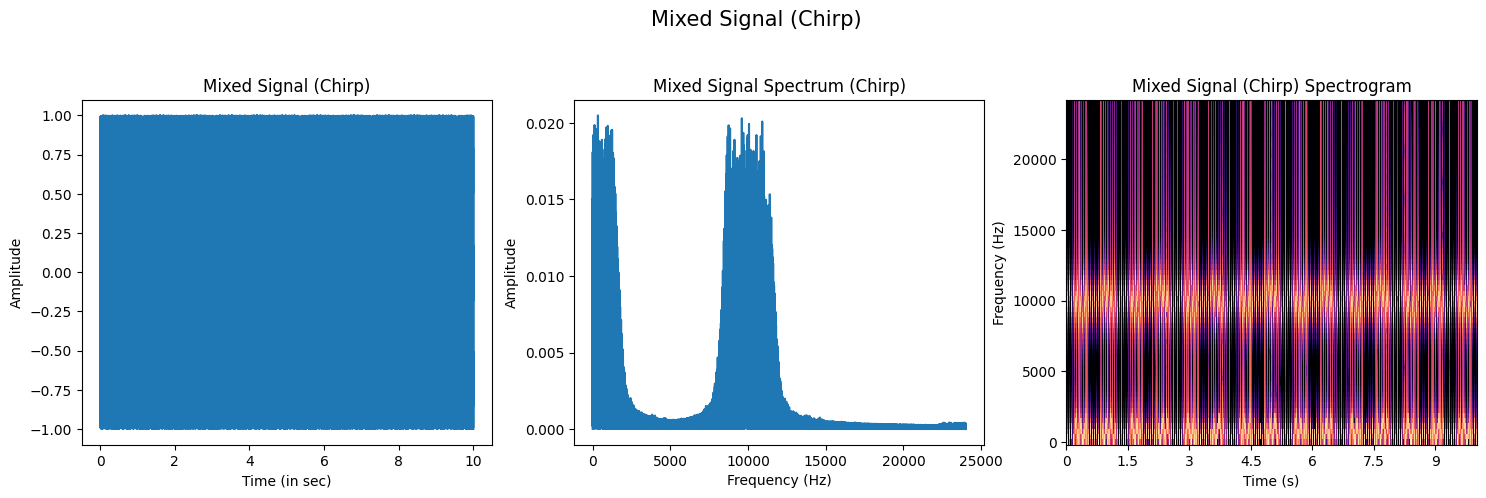

In [30]:
# Mixing Tx and Rx (Chirp) signal 

fig6, (ax1,ax2,ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (18,5))
fig6.suptitle('Mixed Signal (Chirp)', fontsize = 15)

# Time vs Amplitude plot for the 
ax1.plot([i/sampling_rate for i in range(len(mix))], mix)
ax1.set_xlabel("Time (in sec)")
ax1.set_ylabel("Amplitude")
ax1.set_title("Mixed Signal (Chirp)")
#plt.xlim(0,0.1)

# Spectrum
ax2.plot(F_mix, A_mix)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Mixed Signal Spectrum (Chirp)')

# Spectrogram 
plot_spectogram(mix, sampling_rate, title="Mixed Signal (Chirp) Spectrogram", ax = ax3)

plt.subplots_adjust(top=0.8)

##### **IF Signal (for mixed signal (chrip+tone))**

In [31]:
slope = 2000/0.01075
cutoff = (slope * delay_duration) # beat frequnecy fb
cutoff = round(cutoff, 4)
print("Cutoff freq: ",cutoff)

Cutoff freq:  1079.0698


In [32]:
if_signal = butter_lowpass_filter(mixed_chirp_tone, cutoff, sampling_rate, order = 4)

In [33]:
F_if, A_if = compute_fft(if_signal, sampling_rate)

print("Resolution: ", 24000/len(F_if))

all_F_if = [F_if[np.where(A_if == np.sort(A_if)[::-1][i])] for i in range(10)]
print("IF Signal (for mixed signal (chrip+tone)) frequencies: ")
all_F_if

Resolution:  0.09994669509594882
IF Signal (for mixed signal (chrip+tone)) frequencies: 


[array([338.91924307]),
 array([122.93443497]),
 array([252.06556503]),
 array([29.18443497]),
 array([31.58315565]),
 array([245.16924307]),
 array([36.08075693]),
 array([598.58075693]),
 array([432.66924307]),
 array([62.16684435])]

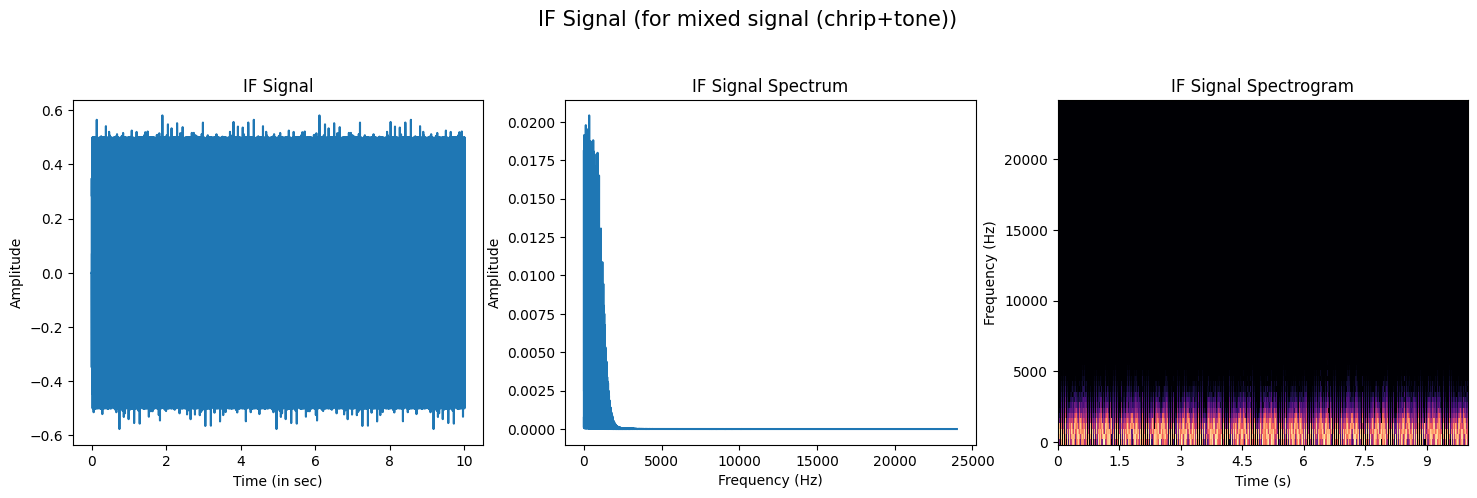

In [34]:
# IF signal 

fig7, (ax1,ax2,ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (18,5))
fig7.suptitle('IF Signal (for mixed signal (chrip+tone))', fontsize = 15)

# Time vs Amplitude plot for the 
ax1.plot([i/sampling_rate for i in range(len(if_signal))], if_signal)
ax1.set_xlabel("Time (in sec)")
ax1.set_ylabel("Amplitude")
ax1.set_title("IF Signal")
#plt.xlim(0,0.1)

# Spectrum
ax2.plot(F_if, A_if)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_title('IF Signal Spectrum')

# Spectrogram 
plot_spectogram(if_signal, sampling_rate, title= 'IF Signal Spectrogram', ax = ax3)

plt.subplots_adjust(top=0.8)